# Bar Chart

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def create_bar_chart(csv_path):
    df = pd.read_csv(csv_path)

    # Convert 0→No and 1→Yes
    df['COUNT'] = df['COUNT'].apply(lambda x: 'Yes' if x == 1 else 'No')

    # Pivot to get No/Yes counts per LABEL
    grouped = df.groupby(['LABEL', 'COUNT']).size().unstack(fill_value=0)
    for col in ['No','Yes']:
        if col not in grouped.columns:
            grouped[col] = 0
    grouped = grouped[['No','Yes']]  # enforce No->Yes order

    fig, ax = plt.subplots(figsize=(8, 4))

    grouped.plot(
        kind='barh',
        stacked=True,
        color=['red','blue'],  # No=red, Yes=blue
        edgecolor='white',
        ax=ax,
        legend=False,
        zorder=2
    )

    # Chart/figure title
    fig.suptitle(
        "Yes/No Vote Counts by Label",
        fontsize=14,
        fontweight='bold',
        y=0.98
    )

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title='Option',
        loc='upper center',
        bbox_to_anchor=(0.5, 0.90),
        ncol=2,
        frameon=True
    )

    fig.subplots_adjust(top=0.75)

    # Axis labels & grid
    ax.set_xlabel("COUNT", fontsize=12, fontweight='bold')
    ax.set_ylabel("LABEL", fontsize=12, fontweight='bold')

    ax.set_axisbelow(True)
    ax.grid(axis='x', color='lightgray', linewidth=1, zorder=0)

    # Skip 0 values
    for container in ax.containers:
        # Build a list of custom labels (empty string if value=0)
        labels = [f'{v:.0f}' if v != 0 else '' for v in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center', color='white')

    plt.savefig("bar_chart.png", dpi=300)
    plt.close()

if __name__ == "__main__":
    create_bar_chart("data/bar_assignment.csv")


# Sankey Diagram

In [30]:
import pandas as pd
import plotly.graph_objects as go

def sankey_flow(csv_path="sankey_assignment.csv"):

    # load dataset
    df = pd.read_csv(csv_path)

    # define the node groups
    entities = ["PS", "OMP", "CNP", "NRP", "NMCCC", "PEC", "NCDM", "RGS"]
    mid_labels = list(df["LABEL"].unique())
    categories = ["Reg", "Aca", "Oth"]

    # combine into a single list for node labeling
    node_list = entities + mid_labels + categories
    node_map = {node: idx for idx, node in enumerate(node_list)}

    node_colors = [
        'salmon',
        'darkcyan',
        'orange',
        'hotpink',
        'lightgreen',
        'cyan',
        'yellow',
        'magenta',
        *[hue for hue in (
            "skyblue","dodgerblue","teal","deepskyblue","aqua",
            "steelblue","lightskyblue","lightblue","azure"
        )[:len(mid_labels)]],
        'darkgreen',
        'lightgreen',
        'green'
    ]

    # Ensure that there's exactly as many colors as nodes
    # by trimming or extending
    diff = len(node_list) - len(node_colors)
    if diff > 0:
        node_colors += [node_colors[-1]] * diff
    elif diff < 0:
        node_colors = node_colors[:len(node_list)]

    # Build up the links (source, target, value, link color)
    s_indices = []
    t_indices = []
    flows = []
    link_shades = []

    # 1) Entities -> mid_labels
    for _, row in df.iterrows():
        lab = row['LABEL']
        for ent in entities:
            val = row[ent]
            if val > 0:
                s_indices.append(node_map[ent])
                t_indices.append(node_map[lab])
                flows.append(val)
                link_shades.append(node_colors[node_map[ent]])

    # 2) mid_labels -> categories
    for _, row in df.iterrows():
        lab = row['LABEL']
        for cat in categories:
            val = row[cat]
            if val > 0:
                s_indices.append(node_map[lab])
                t_indices.append(node_map[cat])
                flows.append(val)
                link_shades.append(node_colors[node_map[lab]])

    fig = go.Figure(
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color='black', width=0.5),
                label=node_list,
                color=node_colors
            ),
            link=dict(
                source=s_indices,
                target=t_indices,
                value=flows,
                color=link_shades
            )
        )
    )

    fig.update_layout(
        title_text="Mapping Entities to Labels and Categories via Sankey",
        font_size=15,
        width=1000,
        height=600
    )

    fig.show()

if __name__ == "__main__":
    sankey_flow("data/sankey_assignment.csv")


# Network Graph

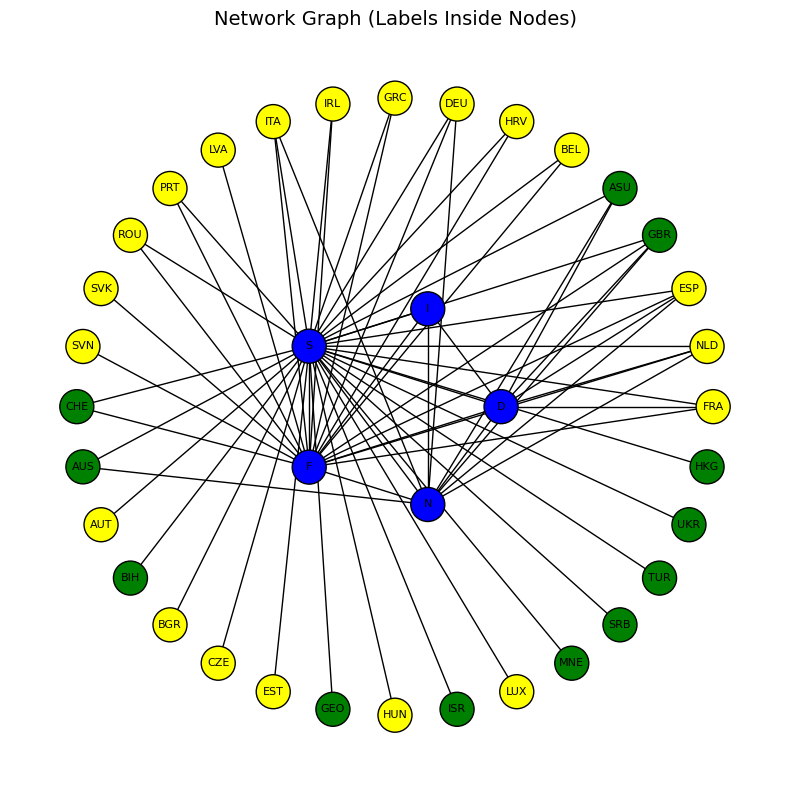

In [28]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math

def create_network_graph(csv_path="network_assignment.csv"):

    # Load CSV
    df = pd.read_csv(csv_path)

    # Build graph from CSV
    G = nx.Graph()
    columns = list(df.columns)
    node_cols = columns[1:]  # skip the LABELS column
    for _, row in df.iterrows():
        row_node = row["LABELS"]
        G.add_node(row_node)
        for c in node_cols:
            val = row[c]
            if val > 0:  # create an edge if >0
                if c != row_node:
                    G.add_edge(row_node, c, weight=val)

    # Define color sets
    center_nodes = {"D","F","I","N","S"}
    green_nodes = {"BIH","GEO","ISR","MNE","SRB","CHE","TUR","UKR","GBR","AUS","HKG","USA", "ASU"}
    yellow_nodes = {"AUT","BEL","BGR","HRV","CZE","EST","FRA","DEU","GRC","HUN","IRL",
                    "ITA","LVA","LUX","NLD","PRT","ROU","SVK","SVN","ESP"}

    # Color map
    color_map = []
    for node in G.nodes():
        if node in center_nodes:
            color_map.append("blue")
        elif node in green_nodes:
            color_map.append("green")
        elif node in yellow_nodes:
            color_map.append("yellow")
        else:
            color_map.append("gray")

    # Position nodes
    star_order = ["D","F","I","N","S"]
    star_jumps = [0,2,4,1,3]  # standard star indexing
    center_positions = {}
    r_center = 1.0
    for i, idx in enumerate(star_jumps):
        node_name = star_order[idx]
        angle = 2*math.pi*(i/5)
        x = r_center*math.cos(angle)
        y = r_center*math.sin(angle)
        center_positions[node_name] = (x, y)

    # Outer ring for others
    outside_nodes = [n for n in G.nodes() if n not in star_order]
    outside_positions = {}
    r_outside = 3.0
    for i, node_name in enumerate(outside_nodes):
        angle = 2*math.pi*(i/len(outside_nodes))
        x = r_outside*math.cos(angle)
        y = r_outside*math.sin(angle)
        outside_positions[node_name] = (x, y)

    # Merge
    pos = {**center_positions, **outside_positions}

    plt.figure(figsize=(8,8))

    # Edges
    nx.draw_networkx_edges(G, pos, edge_color="black", width=1)

    # Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_color=color_map,
        node_size=600,
        edgecolors="black"
    )

    # label customization
    nx.draw_networkx_labels(
        G, pos,
        font_color="black", 
        font_size=8, 
        font_weight="normal" 
    )

    plt.title("Network Graph with Central Pentagram", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("network_graph.png", dpi=300)
    plt.show()
    plt.close()

if __name__ == "__main__":
    create_network_graph("data/networks_assignment.csv")
